# Goal

The goal of this notebook is to perform the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) classification task using convolutionnal neural networks.

We start by importing all the libraries that we will need for this activity.

In [7]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms

# Data loading

We download the FashionMNIST dataset using the torchvision.datasets module.


In [8]:
fashion_mnist_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(
    root      = '../data',
    train     = True,
    download  = True,
    transform = fashion_mnist_transforms
)

test_dataset = datasets.FashionMNIST(
    root      = '../data',
    train     = False,
    download  = True,
    transform = fashion_mnist_transforms
)

Now that our dataset is loaded, let's display the shape of an example.

In [9]:
img, label = train_dataset[0]
print('Image shape', img.shape)
print('Label index', label)

Image shape torch.Size([1, 28, 28])
Label index 9


# Data visualization

Now, as we have done in the previous session, let's display a few elements of the dataset using matplotlib. First we fetch the list of labels from the dataset github page (https://github.com/zalandoresearch/fashion-mnist#labels)

In [10]:
labels = ['T-shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Then we unpack the first element of our dataset. We select the first (and only) color channel in order to be compatible with what `imshow` requires.

Label of training sample 0: Ankle boot


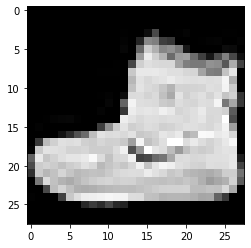

In [11]:
img, label_idx = train_dataset[0]
img = img[0] # For black and white images, imshow requires a shape [height x width]
             # instead of a shape [height x width x channel (RGB)]
label = labels[label_idx]
plt.imshow(img, cmap = 'gray')
print('Label of training sample 0:', label)

Label of testing sample 244: Shirt


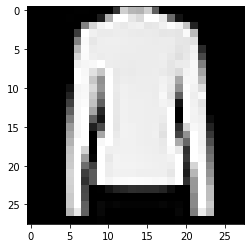

In [12]:
img, label_idx = test_dataset[244]
img = img[0] # For black and white images, imshow requires a shape [height x width]
             # instead of a shape [height x width x channel (RGB)]
label = labels[label_idx]
plt.imshow(img, cmap = 'gray')
print('Label of testing sample 244:', label)

# Neural network definition

Fill the following class to meet the following specification:

- The model contains the following layers:
    - 2 convolution layers, one with 32 filters and the other one with 64 filters,
    - 3 linear layers, two with 64 neurons and one with 10 neurons (the output layer) 
- We perform a max pooling operation after each convolution layer.
- As we have seen with the VGG16 example, after having applied a sequence of convolution and max pooling, the data has to be flattened before being fed to linear layers. At the end of the convolutional part of the model, the data will be of the `[Number of samples, Number of channel output by the last convolution, height, width]` and we need to reshape it into a form `[Number of samples, Number of features]` to be able to use linear layers. Compute the number of features that we will have on each sample to size the first linear layer and reshape the tensor accordingly. 

In [13]:
class CNNMNIST(nn.Module):
    def __init__(self):
        super(CNNMNIST, self).__init__()
        self.conv_1 = nn.Conv2d(
            in_channels = 1,
            out_channels = 32,
            kernel_size = (3, 3),
            padding = 1
        )
        self.conv_2 = nn.Conv2d(
            in_channels = 32,
            out_channels = 64,
            kernel_size = (3, 3),
            padding = 1
        )
        self.linear_layer_1 = nn.Linear(7 * 7 * 64, 64)
        self.linear_layer_2 = nn.Linear(64, 64)
        self.linear_layer_3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv_2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = x.view(x.shape[0], -1)
        x = self.linear_layer_1(x)
        x = F.relu(x)
        x = self.linear_layer_2(x)
        x = F.relu(x)
        x = self.linear_layer_3(x)
        x = torch.log_softmax(x, dim = 1)

        return x

We keep exactly the same `evaluate` and `train` function as before as we are only changing the dataset on which we are working.

In [14]:
def evaluate(model, dataset, batch_size, fast_eval = True):
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

    correct_pred = 0
    total_pred   = 0
    if fast_eval:
        n_batch_to_run = len(dataloader) // 10
    else:
        n_batch_to_run = len(dataloader)
    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            # Once we have been through the specified number of batches,
            # we "break" out of the evaluation loop. 
            if i == n_batch_to_run:
                break
            y_pred        = model(X)
            y_pred_class  = y_pred.argmax(dim = 1)
            correct_pred += (y_pred_class == y).sum().item()
            total_pred   += len(y)

    return correct_pred / total_pred

def train(model, criterion, optimizer, train_dataset, test_dataset, epochs, batch_size):
    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

    for epoch in range(epochs):
        for batch_id, (X, y) in enumerate(train_dataloader):
            y_pred = model(X)
            loss   = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Model evaluation twice per epoch.
            if batch_id % 500 == 0:
              print(
                  f'[Epoch {epoch:3}][Batch {batch_id:5}] -> '
                  f'{100 * evaluate(model, train_dataset, batch_size):5.3f}% training accuracy '
                  f'{100 * evaluate(model, test_dataset, batch_size):5.3f}% testing accuracy'
              )


Now that everything is in place, the only thing left to do is to write the main function of the program which will launch the training process.

Fill this function to meet the following specification:

- The training will run for 20 epochs,
- The batch size is 64,
- The learning rate is 0.001,
- The optimizer is the stochastic gradient descent algorithm.

Along its training process, the model should reach a classification accuracy of around 99% on the testing data. We reach this extremely good result because we have chosen a model architecture (by using convolutions) that is well suited to find patterns in our data.

In [15]:
def main(train_dataset, test_dataset):
  epochs        = 20
  batch_size    = 64
  learning_rate = 0.001
  model         = CNNMNIST()
  criterion     = nn.NLLLoss()
  optimizer     = optim.SGD(
    params = model.parameters(),
    lr     = learning_rate
  )
  
  train(model, criterion, optimizer, train_dataset, test_dataset, epochs, batch_size)

main(train_dataset, test_dataset)

[Epoch   0][Batch     0] -> 9.694% training accuracy 10.208% testing accuracy
[Epoch   0][Batch   500] -> 9.728% training accuracy 7.917% testing accuracy
[Epoch   1][Batch     0] -> 10.870% training accuracy 10.208% testing accuracy
[Epoch   1][Batch   500] -> 18.548% training accuracy 19.583% testing accuracy
[Epoch   2][Batch     0] -> 20.094% training accuracy 16.354% testing accuracy
[Epoch   2][Batch   500] -> 28.797% training accuracy 29.167% testing accuracy
[Epoch   3][Batch     0] -> 33.871% training accuracy 34.062% testing accuracy
[Epoch   3][Batch   500] -> 43.078% training accuracy 40.000% testing accuracy
[Epoch   4][Batch     0] -> 58.266% training accuracy 56.146% testing accuracy
[Epoch   4][Batch   500] -> 60.047% training accuracy 57.708% testing accuracy
[Epoch   5][Batch     0] -> 60.198% training accuracy 58.021% testing accuracy
[Epoch   5][Batch   500] -> 63.239% training accuracy 60.000% testing accuracy
[Epoch   6][Batch     0] -> 63.911% training accuracy 6